<a href="https://colab.research.google.com/github/amirkasaei/Image-Segemntation-CamVid/blob/main/SegNet_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**

In [ ]:
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Input, Softmax, BatchNormalization, Dropout, Conv2D, Flatten, MaxPooling2D, AveragePooling2D, Activation, add, ZeroPadding2D, UpSampling2D, concatenate, Reshape
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam, Adamax, Nadam, SGD
from tensorflow.keras import Model
from tensorflow.keras.optimizers.schedules import InverseTimeDecay, ExponentialDecay
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import seaborn as sns
from copy import deepcopy


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from sklearn.model_selection import KFold


import os
import sys
import time
import cv2 as cv

**GPU**

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# **Preprocess**

### **Google Drive mount**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/dataset/CamVid/"

### **Data Visualization**

#### **random sample**
(image, segmented image)

In [ ]:
img = np.array(load_img(path + 'camvid/images/' + '0001TP_006690.png'))
mask = np.array(load_img(path + 'LabeledApproved/' + '0001TP_006690_L.png'))

#### **original shape of data**

In [ ]:
original_input_shape = np.array(img).shape
original_input_shape

(720, 960, 3)

#### **plotting the original image and its mask**

Text(0.5, 1.0, 'Mask')

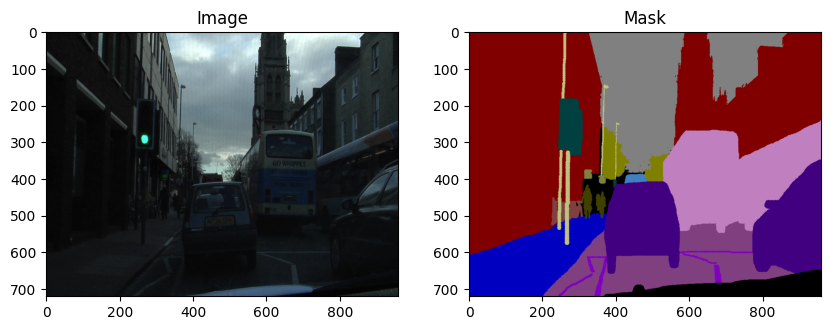

In [ ]:
fig, arr = plt.subplots(1, 2, figsize=(10, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Mask')

#### **resize images**

In [ ]:
# scale for resizing images with cv2 library
scale = 0.16666

In [ ]:
# resizing iamge and mask
resized_img = cv.resize(img, (0,0), fx=scale, fy=scale)/255.0
resized_mask = cv.resize(mask, (0,0), fx=scale, fy=scale)
resized_img.shape # resized shape

(120, 160, 3)

#### **plotting the resized image and its mask**

Text(0.5, 1.0, 'Mask')

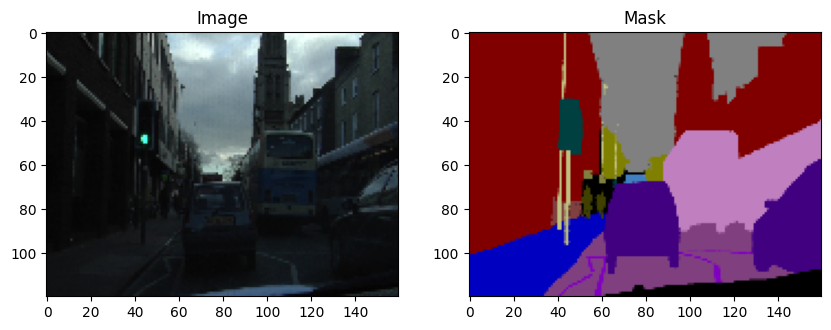

In [ ]:
fig, arr = plt.subplots(1, 2, figsize=(10, 10))
arr[0].imshow(resized_img)
arr[0].set_title('Image')
arr[1].imshow(resized_mask)
arr[1].set_title('Mask')

### **Feature Adjustment**

#### **output color classes**

In [ ]:
classes = pd.read_csv(path + 'class_dict.csv', index_col=0) # class name and its rgb color
classes

,r,g,b
name,,,
Animal,64,128,64
Archway,192,0,128
Bicyclist,0,128,192
Bridge,0,128,64
Building,128,0,0
Car,64,0,128
CartLuggagePram,64,0,192
Child,192,128,64
Column_Pole,192,192,128


In [ ]:
n_classes = len(classes) # number of output color classes
n_classes

32

In [ ]:
classes.index # name of output color classes

Index(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone', 'TrafficLight',
       'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void',
       'Wall'],
      dtype='object', name='name')

In [ ]:
cls2rgb = {cl:list(classes.loc[cl, :]) for cl in classes.index} # dic from class name to its rgb  color

In [ ]:
idx2rgb={idx:np.array(rgb) for idx, (cl, rgb) in enumerate(cls2rgb.items())} # dic from class index to rgb  color

#### **convert original mask to 32 channel mask and reverse**

In [ ]:
# convert mask to 32 channel image
def adjust_mask(mask, flat=False):
    semantic_map = []
    for colour in list(cls2rgb.values()): # creatingg a channel for each color class
        equality = np.equal(mask, colour) # check equal class color in mask image
        class_map = np.all(equality, axis = -1) # create channel accoording to color equality
        semantic_map.append(class_map) # add created channel
    semantic_map = np.stack(semantic_map, axis=-1)
    return np.float32(semantic_map)

In [ ]:
# map the index back to rgb
def map_class_to_rgb(p):
  return idx2rgb[p[0]]

In [ ]:
# covert back 32 chhannel mask to original shape (3 channel image)
def unadjust_mask(new_mask):
  return np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(new_mask, axis=-1), -1))

In [ ]:
# convert orgignal mask to 32 channel
new_mask = adjust_mask(resized_mask)
new_mask.shape

(120, 160, 32)

In [ ]:
# convert  back 32 channel mask to original shape
rgb_mask = unadjust_mask(new_mask)
rgb_mask.shape

(120, 160, 3)

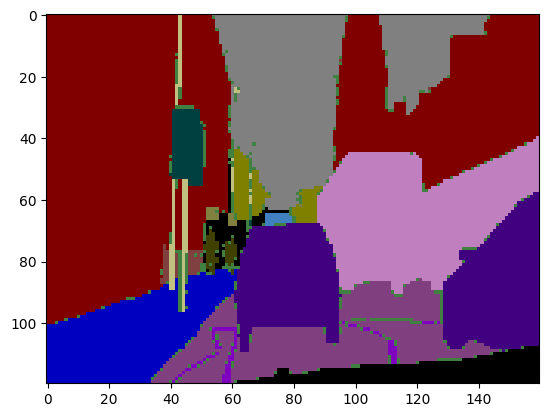

In [ ]:
# plotting the conversion processes mask
plt.imshow(rgb_mask)

### **Load images**

In [ ]:
images, masks = [], []
for filename in os.listdir(path + 'camvid/images/'):
  # read image
  img = np.array(load_img(path + 'camvid/images/' + filename))
  # read mask
  mask = np.array(load_img(path + 'LabeledApproved/' + filename[:-4] + '_L.png'))

  if img is not None and mask is not None: # check if non of them is null
    # resizing and normalizing image
    img = cv.resize(mask, (0,0), fx=scale, fy=scale)/255.0

    # resizing mask
    mask = cv.resize(mask, (0,0), fx=scale, fy=scale)
    # converting to 32 channel image
    mask = adjust_mask(mask)

    images.append(img)
    masks.append(mask)

### **Feature Selection**

In [ ]:
input_shape = images[0].shape # input shape
input_shape

(120, 160, 3)

In [ ]:
# split data into 90% train set and  10% test set (we split train set into train and valid set whiile fitting the model)
x_train, x_test, y_train, y_test = train_test_split(np.array(images), np.array(masks), test_size=0.1)

In [ ]:
y_test.shape # test set outpuutt shape

(71, 120, 160, 32)

In [ ]:
# train set input and outputt shape
x_train.shape, y_train.shape

((630, 120, 160, 3), (630, 120, 160, 32))

# **Model**

## **Helper Function**

In [ ]:
def plot_confusionmatrix(y_pred,y_true, classes):
  print('Confusion matrix')
  cf = confusion_matrix(y_pred,y_true)
  sns.heatmap(cf,annot=True,yticklabels=classes, xticklabels=classes, cmap='Blues', fmt='g')
  plt.tight_layout()
  plt.show()

In [ ]:
# plot model results
def showPlots(history):
    plt.plot(history['accuracy'], label='training accuracy', marker='.', color='green')
    plt.plot(history['val_accuracy'], label='validation accuracy', marker='.', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history['loss'], label='training loss', marker='.', color='red')
    plt.plot(history['val_loss'], label='validation loss', marker='.', color='yellow')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## **Implementation**

In [ ]:
kernel_size = 7
filter_size = 64
pool_size = 2
height = input_shape[0]
width = input_shape[1]
data_shape = input_shape[0]*input_shape[1]
batch_normalization = True

In [ ]:
inputs = Input(shape=input_shape)
# ------------------------------------ down 1----------------------------------------
conv1 = Conv2D(filter_size, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
if(batch_normalization):
  conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
# ------------------------------------ down 2 ----------------------------------------
conv2 = Conv2D(2*filter_size, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
if(batch_normalization):
  conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
# ------------------------------------ down 3 ----------------------------------------
conv3 = Conv2D(4*filter_size, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
if(batch_normalization):
  conv3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
# ------------------------------------ down 4 ----------------------------------------
conv4 = Conv2D(8*filter_size, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
if(batch_normalization):
  conv4 = BatchNormalization()(conv4)


# ------------------------------------ up 1 ----------------------------------------
up5 = Conv2D(8*filter_size, 2, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv4)
conv5 = Conv2D(8*filter_size, kernel_size, activation = None , padding = 'same', kernel_initializer = 'he_normal')(up5)
if(batch_normalization):
  conv5 = BatchNormalization()(conv5)
# ------------------------------------ up 2 ----------------------------------------
up6 = Conv2D(4*filter_size, 2, activation = None, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
conv6 = Conv2D(4*filter_size, kernel_size, activation = None, padding = 'same', kernel_initializer = 'he_normal')(up6)
if(batch_normalization):
  conv6 = BatchNormalization()(conv6)
# ------------------------------------ up 3 ----------------------------------------
up7 = Conv2D(2*filter_size, 2, activation = None, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
conv7 = Conv2D(2*filter_size, kernel_size, activation = None, padding = 'same', kernel_initializer = 'he_normal')(up7)
if(batch_normalization):
  conv7 = BatchNormalization()(conv7)
# ------------------------------------ up 4 ----------------------------------------
up8 = Conv2D(filter_size, 2, activation = None, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
conv8 = Conv2D(filter_size, kernel_size, activation = None, padding = 'same', kernel_initializer = 'he_normal')(up8)
if(batch_normalization):
  conv8 = BatchNormalization()(conv8)
# ---------------------------------- output ----------------------------------------
convOut = Conv2D(n_classes, (1,1), padding='same')(conv8)
outputs = Activation('softmax')(convOut)


### **without batch norm**

In [ ]:
segnet = Model(inputs, outputs)
segnet.summary()
segnet.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 160, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 120, 160, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 80, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 80, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 40, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 40, 256)       160588

### **with batch norm**

In [ ]:
segnet_bn = Model(inputs, outputs)
segnet_bn.summary()
segnet_bn.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 160, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 120, 160, 64)      9472      
                                                                 
 batch_normalization (BatchN  (None, 120, 160, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 80, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 80, 128)       401536    
                                                                 
 batch_normalization_1 (Batc  (None, 60, 80, 128)      512   

## **Train**

### **without batch norm**

In [ ]:
# saving best model based on hihest accuracy on validation set
model_checkpoint = ModelCheckpoint('segnet_camvid.hdf5', monitor='val_accuracy', save_best_only=True)

In [ ]:
with tf.device('/GPU:0'):
  history = segnet.fit(x_train, y_train, validation_split=0.1, epochs=30, batch_size=16, callbacks=[model_checkpoint])

Epoch 1/30
36/36 [==============================] - 59s 1s/step - loss: 9.2359 - accuracy: 0.5053 - val_loss: 1.0995 - val_accuracy: 0.7155
Epoch 2/30
36/36 [==============================] - 26s 739ms/step - loss: 0.9608 - accuracy: 0.7381 - val_loss: 0.8446 - val_accuracy: 0.7576
Epoch 3/30
36/36 [==============================] - 31s 876ms/step - loss: 0.7185 - accuracy: 0.7878 - val_loss: 0.6609 - val_accuracy: 0.7957
Epoch 4/30
36/36 [==============================] - 35s 974ms/step - loss: 0.5886 - accuracy: 0.8159 - val_loss: 0.5774 - val_accuracy: 0.8147
Epoch 5/30
36/36 [==============================] - 16s 445ms/step - loss: 0.6287 - accuracy: 0.8117 - val_loss: 0.9473 - val_accuracy: 0.7473
Epoch 6/30
36/36 [==============================] - 37s 1s/step - loss: 0.6772 - accuracy: 0.7991 - val_loss: 0.5644 - val_accuracy: 0.8171
Epoch 7/30
36/36 [==============================] - 16s 451ms/step - loss: 1.0935 - accuracy: 0.7524 - val_loss: 0.7502 - val_accuracy: 0.7763
Epoch

### **with batch norm**

In [ ]:
# saving best model based on hihest accuracy on validation set
model_checkpoint = ModelCheckpoint('segnet_bn_camvid.hdf5', monitor='val_accuracy', save_best_only=True)

In [ ]:
with tf.device('/GPU:0'):
  history_bn = segnet_bn.fit(x_train, y_train, validation_split=0.1, epochs=40, batch_size=16, callbacks=[model_checkpoint])

Epoch 1/40
36/36 [==============================] - 82s 2s/step - loss: 0.9631 - accuracy: 0.7564 - val_loss: 4.0845 - val_accuracy: 0.4518
Epoch 2/40
36/36 [==============================] - 32s 898ms/step - loss: 0.5375 - accuracy: 0.8396 - val_loss: 1.4097 - val_accuracy: 0.6051
Epoch 3/40
36/36 [==============================] - 33s 931ms/step - loss: 0.4308 - accuracy: 0.8617 - val_loss: 1.4252 - val_accuracy: 0.6756
Epoch 4/40
36/36 [==============================] - 37s 1s/step - loss: 0.3619 - accuracy: 0.8761 - val_loss: 1.1889 - val_accuracy: 0.7542
Epoch 5/40
36/36 [==============================] - 35s 999ms/step - loss: 0.3279 - accuracy: 0.8834 - val_loss: 1.0129 - val_accuracy: 0.8031
Epoch 6/40
36/36 [==============================] - 33s 932ms/step - loss: 0.2932 - accuracy: 0.8913 - val_loss: 0.8101 - val_accuracy: 0.8319
Epoch 7/40
36/36 [==============================] - 38s 1s/step - loss: 0.2731 - accuracy: 0.8959 - val_loss: 0.7098 - val_accuracy: 0.8450
Epoch 8/

## **Evaluation**

### **without Batch Normalization**

#### **model results**

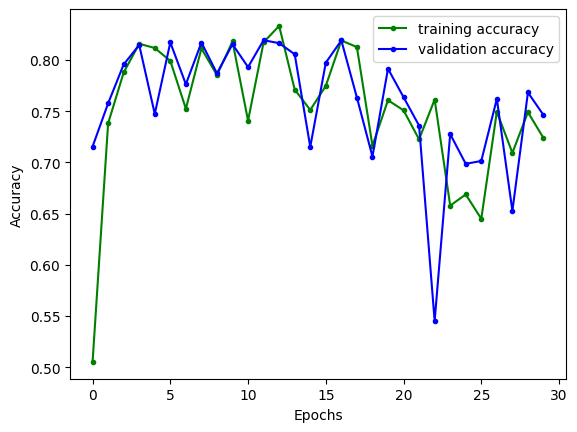

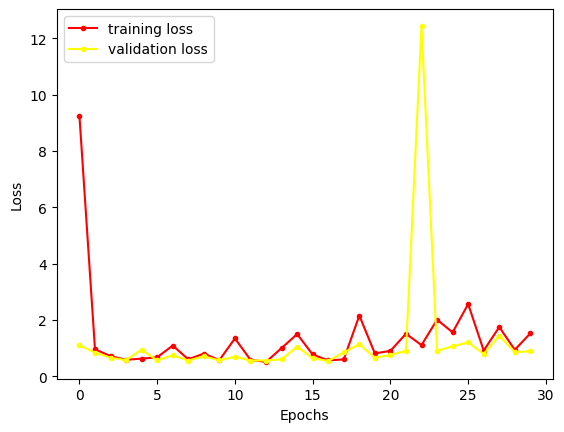

In [ ]:
showPlots(history.history)

#### **best model evaluation**

In [ ]:
# loading best model
segnet = load_model('segnet_camvid.hdf5')

In [ ]:
# evaluate on test set
segnet.evaluate(x_test, y_test, batch_size=32)

3/3 [==============================] - 10s 135ms/step - loss: 0.5270 - accuracy: 0.8295


[0.5270076394081116, 0.8294997215270996]

In [ ]:
y_pred = segnet.predict(x_test)

3/3 [==============================] - 1s 159ms/step


#### **plotting output**

In [ ]:
rgb_mask_pred = unadjust_mask(y_pred[0]) # predicted output
rgb_mask_true = unadjust_mask(y_test[0]) # actual output

Text(0.5, 1.0, 'Pred Mask')

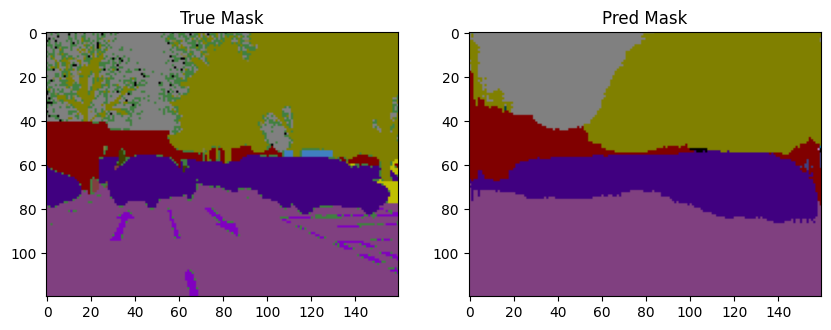

In [ ]:
fig, arr = plt.subplots(1, 2, figsize=(10, 10))
arr[0].imshow(rgb_mask_true)
arr[0].set_title('True Mask')
arr[1].imshow(rgb_mask_pred)
arr[1].set_title('Pred Mask')

### **Batch Normalization**

#### **model results**

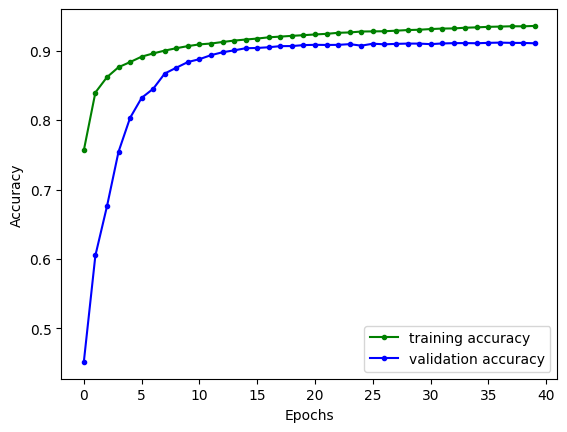

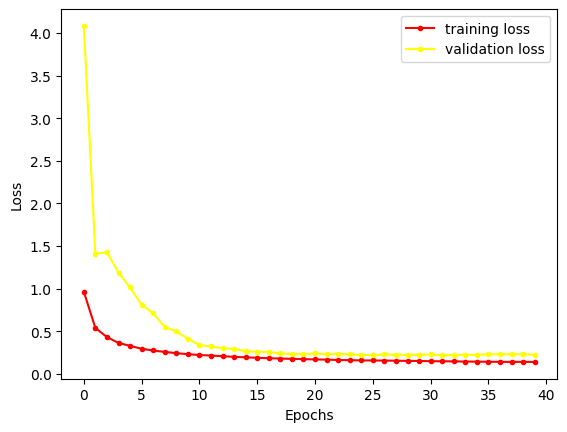

In [ ]:
showPlots(history_bn.history)

#### **best model evaluation**

In [ ]:
# loading best model
segnet_bn = load_model('segnet_bn_camvid.hdf5')

In [ ]:
# evaluate on test set
segnet_bn.evaluate(x_test, y_test, batch_size=32)

3/3 [==============================] - 10s 140ms/step - loss: 0.2378 - accuracy: 0.9051


[0.23776589334011078, 0.9051371812820435]

In [ ]:
y_pred = segnet_bn.predict(x_test)

3/3 [==============================] - 1s 160ms/step


#### **plotting output**

In [ ]:
rgb_mask_pred = unadjust_mask(y_pred[0]) # predicted output
rgb_mask_true = unadjust_mask(y_test[0]) # actual output

Text(0.5, 1.0, 'Pred Mask')

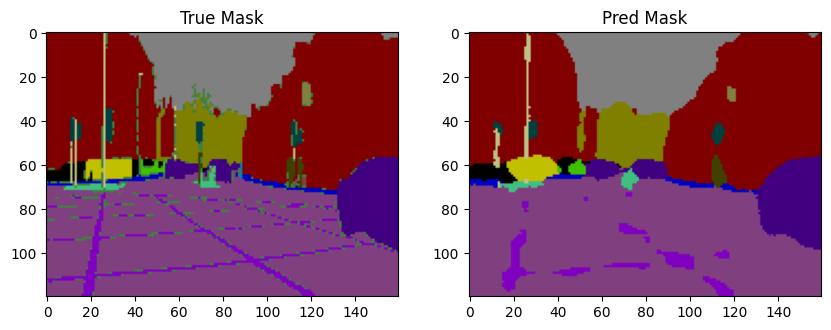

In [ ]:
fig, arr = plt.subplots(1, 2, figsize=(10, 10))
arr[0].imshow(rgb_mask_true)
arr[0].set_title('True Mask')
arr[1].imshow(rgb_mask_pred)
arr[1].set_title('Pred Mask')